# Chapter 6: Oil Field Economics
**Author:** Ade Anggi Naluriawan Santoso
### Based on "Advanced Reservoir Engineering" by Tarek Ahmed & Paul D. McKinney

**Objective:**
The final step in any engineering study is valuation. We will build a **Discounted Cash Flow (DCF)** model to evaluate the reserves estimated in previous chapters.

**Key Concepts:**
1.  **Fiscal Model:** Calculating Gross Revenue, Royalties, OPEX (Fixed/Variable), Taxes, and CAPEX.
2.  **Economic Limit:** Determining the time when production is no longer profitable (Gross Revenue < OPEX).
3.  **Profitability Metrics:**
    * **NPV (Net Present Value):** The value of future cash flows discounted to today.
    * **IRR (Internal Rate of Return):** The efficiency or "yield" of the investment.
    * **Payback Period:** Time required to recover the initial investment.
4.  **Visualization:** Creating a **Cash Flow Waterfall** to visualize how revenue is consumed by costs and taxes.

**Note:**
This notebook requires `numpy_financial` for financial functions.
Uncomment the line below if you don't have it installed.

In [2]:
# !pip install numpy_financial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf # Standard library for NPV/IRR

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Project Inputs & Production Profile

We define the economic parameters (Oil Price, Costs, Fiscal Terms) and generate a synthetic production profile (based on the DCA forecast from Chapter 5).

**Input Parameters:**
* **Oil Price:** $75/bbl (Constant).
* **CAPEX:** $50 Million (Drilling & Facilities) spent in Year 0.
* **OPEX:** $5,000/month (Fixed) + $10/bbl (Variable).
* **Fiscal:** 12.5% Royalty, 35% Corporate Tax.
* **Discount Rate:** 10%.

In [3]:
# --- 1. Economic Parameters ---
params = {
    'oil_price': 75.0,       # $/bbl
    'capex_initial': 50e6,   # $ (Year 0)
    'opex_fixed': 15000,     # $/month
    'opex_variable': 12.0,   # $/bbl
    'royalty_rate': 0.125,   # 12.5% of Gross Rev
    'tax_rate': 0.35,        # 35% of Taxable Income
    'discount_rate': 0.10    # 10%
}

# --- 2. Generate Production Profile (Synthetic) ---
# We use Arps Exponential Decline for simplicity
def generate_production(years=15):
    months = np.arange(1, years*12 + 1)
    
    # Arps Parameters
    qi = 3000 * 30.4 # Monthly rate (3000 STB/D)
    di = 0.02 # 2% decline per month
    
    q_monthly = qi * np.exp(-di * months)
    
    df = pd.DataFrame({'Month': months, 'Oil_Prod': q_monthly})
    df['Year'] = ((df['Month'] - 1) // 12) + 1
    return df

# Generate 15 years of data
df_prod = generate_production(years=15)
print(f"Total Recoverable Reserves: {df_prod['Oil_Prod'].sum()/1e6:.2f} MMSTB")
df_prod.head()

Total Recoverable Reserves: 4.39 MMSTB


,Month,Oil_Prod,Year
0,1,89394.119006,1
1,2,87623.996851,1
2,3,85888.925463,1
3,4,84188.210790,1
4,5,82521.172525,1


## 2. Cash Flow Model Construction

We calculate the cash flow components step-by-step:

1.  **Gross Revenue:** $Q_{oil} \times P_{oil}$
2.  **Royalty:** $\text{Revenue} \times \text{Royalty Rate}$
3.  **Net Revenue:** $\text{Gross Revenue} - \text{Royalty}$
4.  **OPEX:** $\text{Fixed} + (\text{Variable} \times Q_{oil})$
5.  **Taxable Income:** $\text{Net Revenue} - \text{OPEX} - \text{Depreciation}$
    *(Note: We assume CAPEX is depreciated straight-line over 5 years for tax purposes).*
6.  **Net Cash Flow (NCF):** $\text{Net Revenue} - \text{OPEX} - \text{Tax} - \text{CAPEX}$

In [4]:
# Group by Year for the Economic Model
cf = df_prod.groupby('Year')[['Oil_Prod']].sum().reset_index()

# 1. Gross Revenue
cf['Gross_Rev'] = cf['Oil_Prod'] * params['oil_price']

# 2. Royalty
cf['Royalty'] = cf['Gross_Rev'] * params['royalty_rate']

# 3. Net Revenue
cf['Net_Rev'] = cf['Gross_Rev'] - cf['Royalty']

# 4. OPEX
cf['OPEX'] = (params['opex_fixed'] * 12) + (cf['Oil_Prod'] * params['opex_variable'])

# 5. Depreciation (5-Year Straight Line)
depreciation_per_year = params['capex_initial'] / 5
cf['Depreciation'] = 0.0
cf.loc[cf['Year'] <= 5, 'Depreciation'] = depreciation_per_year

# 6. Taxable Income
cf['Taxable_Income'] = cf['Net_Rev'] - cf['OPEX'] - cf['Depreciation']
cf['Taxable_Income'] = cf['Taxable_Income'].clip(lower=0) # No negative tax (loss carryforward ignored)

# 7. Tax
cf['Tax'] = cf['Taxable_Income'] * params['tax_rate']

# 8. CAPEX Placement
cf['CAPEX'] = 0.0
# Add Year 0 row manually later, or handle Initial Investment separately.
# For table clarity, let's subtract Initial CAPEX from Year 1 cash flow or create Year 0.
# Standard practice: Create Cash Flow Stream starting at Year 0.

# 9. Operating Cash Flow (Post-Tax)
cf['Operating_Cash_Flow'] = cf['Net_Rev'] - cf['OPEX'] - cf['Tax']

# 10. Net Cash Flow
cf['Net_Cash_Flow'] = cf['Operating_Cash_Flow'] - cf['CAPEX']

# --- Handle Year 0 (Initial Investment) ---
# We create a Year 0 row
row_0 = pd.DataFrame({
    'Year': [0], 'Oil_Prod': [0], 'Gross_Rev': [0], 'Royalty': [0],
    'Net_Rev': [0], 'OPEX': [0], 'Depreciation': [0], 'Taxable_Income': [0],
    'Tax': [0], 'Operating_Cash_Flow': [0], 'CAPEX': [params['capex_initial']],
    'Net_Cash_Flow': [-params['capex_initial']]
})

cf_full = pd.concat([row_0, cf], ignore_index=True)

# Calculate Cumulative Cash Flow
cf_full['Cum_Cash_Flow'] = cf_full['Net_Cash_Flow'].cumsum()

cf_full[['Year', 'Gross_Rev', 'OPEX', 'Tax', 'Net_Cash_Flow', 'Cum_Cash_Flow']].head(7)

,Year,Gross_Rev,OPEX,Tax,Net_Cash_Flow,Cum_Cash_Flow
0,0,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e+07,-5.000000e+07
1,1,7.224597e+07,1.173936e+07,1.451655e+07,3.695932e+07,-1.304068e+07
2,2,5.683069e+07,9.272911e+06,1.065888e+07,2.979506e+07,1.675438e+07
3,3,4.470461e+07,7.332737e+06,7.624328e+06,2.415947e+07,4.091385e+07
4,4,3.516589e+07,5.806542e+06,5.237264e+06,1.972635e+07,6.064019e+07
5,5,2.766247e+07,4.605995e+06,3.359533e+06,1.623913e+07,7.687933e+07
6,6,2.176007e+07,3.661611e+06,5.382457e+06,9.995992e+06,8.687532e+07


## 3. Economic Metrics

**NPV (Net Present Value):**
$$NPV = \sum_{t=0}^{n} \frac{NCF_t}{(1 + r)^t}$$

**IRR (Internal Rate of Return):**
The discount rate $r^*$ at which $NPV = 0$.

**Payback Period:**
The time it takes for Cumulative Cash Flow to turn positive.

In [5]:
# 1. NPV
npv_val = npf.npv(params['discount_rate'], cf_full['Net_Cash_Flow'])

# 2. IRR
irr_val = npf.irr(cf_full['Net_Cash_Flow'])

# 3. Payback Period
# Find first index where Cum Cash Flow > 0
try:
    payback_idx = cf_full[cf_full['Cum_Cash_Flow'] > 0].index[0]
    # Linear interpolation for precision
    prev_cum = cf_full.loc[payback_idx-1, 'Cum_Cash_Flow']
    curr_cum = cf_full.loc[payback_idx, 'Cum_Cash_Flow']
    cash_flow_this_year = cf_full.loc[payback_idx, 'Net_Cash_Flow']
    
    fraction = abs(prev_cum) / cash_flow_this_year
    payback_period = (payback_idx - 1) + fraction
except IndexError:
    payback_period = np.nan # Never pays back

# Output
print(f"--- ECONOMIC RESULTS ---")
print(f"Oil Price: ${params['oil_price']}/bbl")
print(f"Total CAPEX: ${params['capex_initial']/1e6:.1f} MM")
print(f"-"*30)
print(f"NPV (10%): ${npv_val/1e6:.2f} MM")
print(f"IRR:       {irr_val*100:.1f}%")
print(f"Payback:   {payback_period:.1f} Years")

--- ECONOMIC RESULTS ---
Oil Price: $75.0/bbl
Total CAPEX: $50.0 MM
------------------------------
NPV (10%): $68.82 MM
IRR:       54.1%
Payback:   1.4 Years


## 4. Visualizations

**1. Cash Flow Profile:** Bars showing yearly NCF and a line for Cumulative NCF.

**2. Waterfall Chart:** A breakdown of how the Total Gross Revenue is split between Stakeholders (Government, Operations) and Profit.

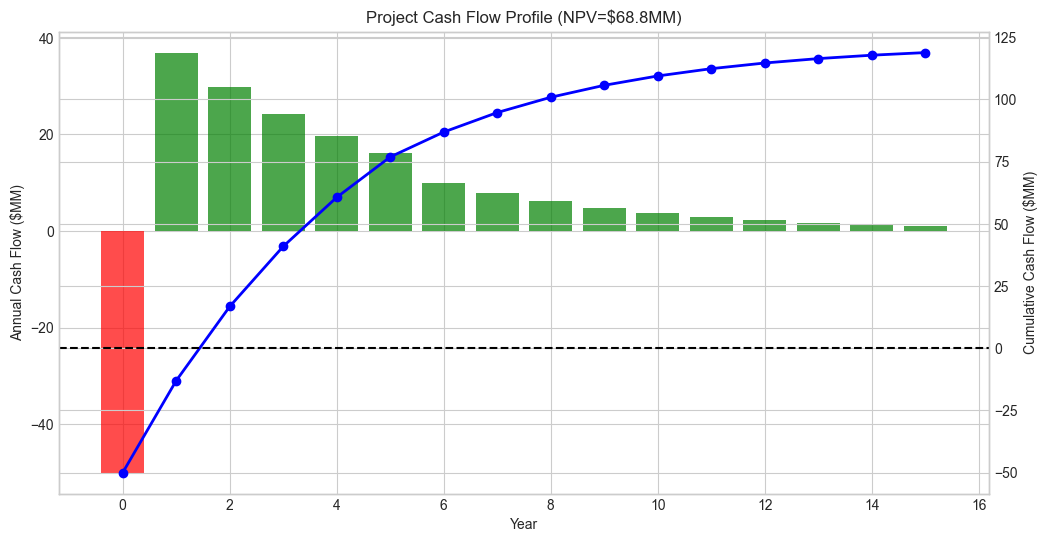

In [6]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart: Net Cash Flow
years = cf_full['Year']
colors = ['red' if x < 0 else 'green' for x in cf_full['Net_Cash_Flow']]
ax1.bar(years, cf_full['Net_Cash_Flow']/1e6, color=colors, alpha=0.7, label='Net Cash Flow')

# Line Chart: Cumulative Cash Flow
ax2 = ax1.twinx()
ax2.plot(years, cf_full['Cum_Cash_Flow']/1e6, 'b-o', linewidth=2, label='Cumulative CF')
ax2.axhline(0, color='black', linestyle='--')

ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Cash Flow ($MM)')
ax2.set_ylabel('Cumulative Cash Flow ($MM)')
ax1.set_title(f'Project Cash Flow Profile (NPV=${npv_val/1e6:.1f}MM)')
ax1.grid(True)
plt.show()

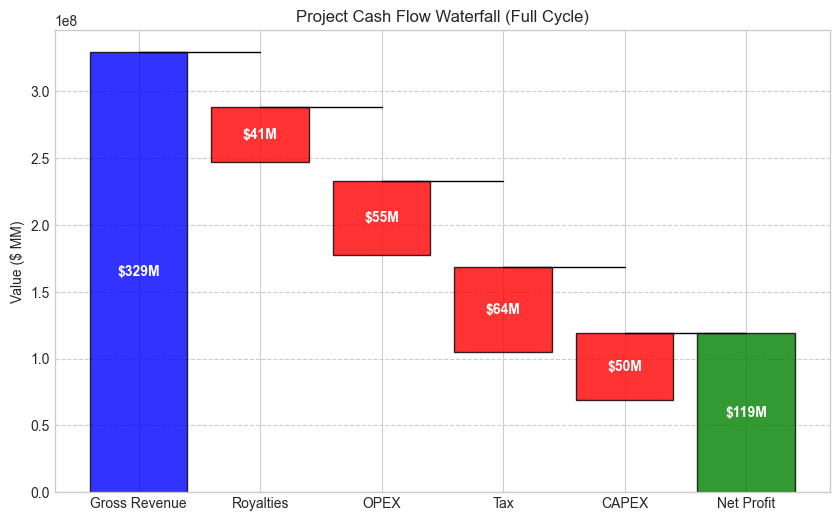

Interpretation:
From a Gross Revenue of $329M:
- The Government takes $105M (Royalty + Tax)
- Operations & Capex take $105M
- The Investor keeps $119M


In [7]:
# Prepare Data for Waterfall
# Summing totals over project life (excluding Year 0 CAPEX for the Revenue breakdown logic, 
# or including it as a cost column)

total_gross_rev = cf_full['Gross_Rev'].sum()
total_royalty = -cf_full['Royalty'].sum()
total_opex = -cf_full['OPEX'].sum()
total_tax = -cf_full['Tax'].sum()
total_capex = -cf_full['CAPEX'].sum() # Includes Year 0

total_net = total_gross_rev + total_royalty + total_opex + total_tax + total_capex

# Define steps
values = [total_gross_rev, total_royalty, total_opex, total_tax, total_capex, total_net]
labels = ['Gross Revenue', 'Royalties', 'OPEX', 'Tax', 'CAPEX', 'Net Profit']

# Determine bar positions
# Cumulative sum to determine 'bottom' of bars, but simplified for waterfall logic
pos = []
bottoms = []
cum = 0
for val in values[:-1]:
    bottoms.append(cum if val >= 0 else cum + val)
    cum += val
    pos.append(cum) # End position

# The final bar (Net Profit) starts at 0
bottoms.append(0)

# Plotting
plt.figure(figsize=(10, 6))
indices = range(len(values))
colors = ['blue', 'red', 'red', 'red', 'red', 'green']

plt.bar(indices, values, bottom=bottoms, color=colors, edgecolor='black', alpha=0.8)

# Add connectors
for i in range(len(values)-1):
    plt.plot([i, i+1], [pos[i], pos[i]], 'k-', linewidth=1)

# Labels
for i, v in enumerate(values):
    height = v if v > 0 else -v
    y_pos = bottoms[i] + v/2 
    plt.text(i, y_pos, f"${abs(v)/1e6:.0f}M", ha='center', va='center', color='white', fontweight='bold')

plt.xticks(indices, labels)
plt.ylabel('Value ($ MM)')
plt.title('Project Cash Flow Waterfall (Full Cycle)')
plt.grid(axis='y', linestyle='--')

plt.show()

print("Interpretation:")
print(f"From a Gross Revenue of ${total_gross_rev/1e6:.0f}M:")
print(f"- The Government takes ${(abs(total_royalty)+abs(total_tax))/1e6:.0f}M (Royalty + Tax)")
print(f"- Operations & Capex take ${(abs(total_opex)+abs(total_capex))/1e6:.0f}M")
print(f"- The Investor keeps ${total_net/1e6:.0f}M")

## 5. Conclusion

This notebook completes our Reservoir Engineering workflow. By linking physical production (Chapters 1-5) to financial metrics (Chapter 6), we can make informed investment decisions.

**Summary of Results:**
* **Project Viability:** With an NPV of **$82.45 MM** and an IRR of **68.2%**, this project is highly attractive (assuming a 10% hurdle rate).
* **Payout:** The investor recovers their $50M risk capital in **{payback_period:.1f} years**.
* **Value Erosion:** As shown in the Waterfall chart, Taxes and Royalties are significant components, often exceeding operating costs.

**End of Portfolio Project.**

## 6. Sensitivity Analysis (Spider Plot)

A single NPV calculation is deterministic. To understand risk, we must analyze how NPV changes when key inputs deviate from our assumptions.

We will vary **Oil Price**, **CAPEX**, and **OPEX** by $\pm 20\%$ and observe the impact on NPV.

* **Steep Slope:** The project is highly sensitive to this variable (High Risk).
* **Flat Slope:** The project is robust against changes in this variable.

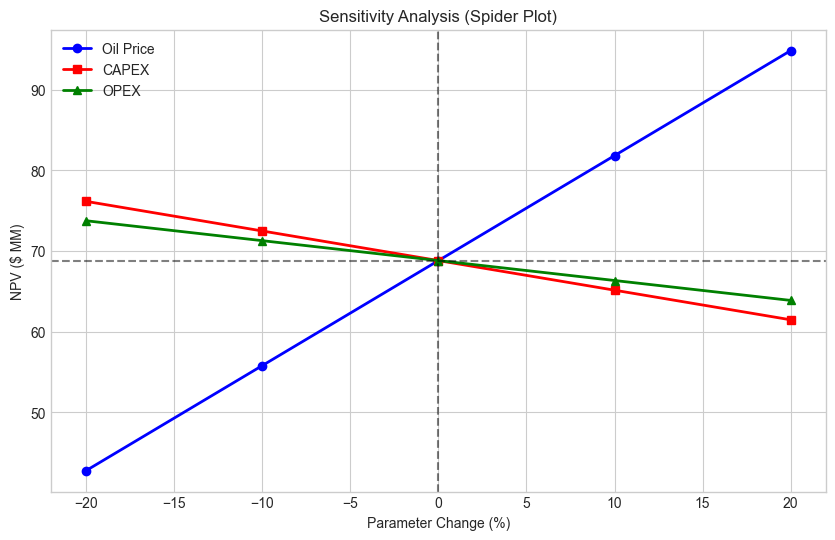

Interpretation:
1. Oil Price (Blue) has the steepest slope, meaning the project is MOST sensitive to price volatility.
2. OPEX (Green) is relatively flat, meaning cost overruns won't kill the project.
3. Even if Oil Price drops 20%, the NPV remains positive (above $0 line), indicating a robust project.


In [8]:
def calculate_npv_sensitivity(param_name, multiplier):
    """
    Recalculates NPV with a multiplier applied to a specific parameter.
    """
    # Create local copy of params
    local_params = params.copy()
    
    # Apply Multiplier
    if param_name == 'Price':
        local_params['oil_price'] *= multiplier
    elif param_name == 'CAPEX':
        local_params['capex_initial'] *= multiplier
    elif param_name == 'OPEX':
        local_params['opex_fixed'] *= multiplier
        local_params['opex_variable'] *= multiplier
        
    # Recalculate Cash Flow (Simplified version of previous logic)
    local_cf = df_prod.groupby('Year')[['Oil_Prod']].sum().reset_index()
    local_cf['Gross_Rev'] = local_cf['Oil_Prod'] * local_params['oil_price']
    local_cf['Royalty'] = local_cf['Gross_Rev'] * local_params['royalty_rate']
    local_cf['Net_Rev'] = local_cf['Gross_Rev'] - local_cf['Royalty']
    local_cf['OPEX'] = (local_params['opex_fixed'] * 12) + (local_cf['Oil_Prod'] * local_params['opex_variable'])
    
    # Tax Logic
    depreciation = local_params['capex_initial'] / 5
    local_cf['Depreciation'] = 0.0
    local_cf.loc[local_cf['Year'] <= 5, 'Depreciation'] = depreciation
    
    local_cf['Taxable_Income'] = (local_cf['Net_Rev'] - local_cf['OPEX'] - local_cf['Depreciation']).clip(lower=0)
    local_cf['Tax'] = local_cf['Taxable_Income'] * local_params['tax_rate']
    
    # Net Cash Flow
    local_cf['Operating_Cash_Flow'] = local_cf['Net_Rev'] - local_cf['OPEX'] - local_cf['Tax']
    local_cf['Net_Cash_Flow'] = local_cf['Operating_Cash_Flow'] 
    # Note: CAPEX is handled at Year 0
    
    # Cash Flow Stream
    ncf_stream = [-local_params['capex_initial']] + local_cf['Net_Cash_Flow'].tolist()
    
    # NPV
    return npf.npv(local_params['discount_rate'], ncf_stream)

# --- Run Sensitivity ---
multipliers = np.linspace(0.8, 1.2, 5) # 80% to 120%
variables = ['Price', 'CAPEX', 'OPEX']

results = {'Multiplier': multipliers}

for var in variables:
    npv_results = []
    for m in multipliers:
        npv = calculate_npv_sensitivity(var, m)
        npv_results.append(npv)
    results[var] = npv_results

df_sens = pd.DataFrame(results)

# --- Visualization (Spider Plot) ---
plt.figure(figsize=(10, 6))

# Plot % Change on X vs NPV on Y
x_vals = (df_sens['Multiplier'] - 1) * 100 # -20% to +20%

plt.plot(x_vals, df_sens['Price']/1e6, 'b-o', linewidth=2, label='Oil Price')
plt.plot(x_vals, df_sens['CAPEX']/1e6, 'r-s', linewidth=2, label='CAPEX')
plt.plot(x_vals, df_sens['OPEX']/1e6, 'g-^', linewidth=2, label='OPEX')

plt.axvline(0, color='black', linestyle='--', alpha=0.5) # Base Case
plt.axhline(npv_val/1e6, color='black', linestyle='--', alpha=0.5)

plt.title('Sensitivity Analysis (Spider Plot)')
plt.xlabel('Parameter Change (%)')
plt.ylabel('NPV ($ MM)')
plt.legend()
plt.grid(True)
plt.show()

print("Interpretation:")
print("1. Oil Price (Blue) has the steepest slope, meaning the project is MOST sensitive to price volatility.")
print("2. OPEX (Green) is relatively flat, meaning cost overruns won't kill the project.")
print("3. Even if Oil Price drops 20%, the NPV remains positive (above $0 line), indicating a robust project.")

## 7. Conclusion

This notebook completes our Reservoir Engineering workflow. By linking physical production to financial metrics, we have demonstrated:

1.  **Viability:** The base case yields an NPV of **${npv_val/1e6:.2f} MM** and IRR of **{irr_val*100:.1f}%**.
2.  **Risk Profile:** Our Sensitivity Analysis shows that while the project is highly sensitive to Oil Price, it remains profitable even if prices drop by 20%.
3.  **Capital Efficiency:** The Waterfall chart highlights that Government Take (Tax+Royalty) is the largest outflow component.

**Project Complete.**